In [1]:
import pandas as pd
import numpy as np 
from utils import *
import os
import seaborn as sns
import re
import treeswift
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import tol_colors as tc
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

%matplotlib inline

# Load SC1 and SC2 NRRs

In [2]:
sc1_like_bps = [2090, 2977, 3400, 4268, 5532, 6336, 7074, 8481, 9048, 9357, 10821, 12969, 15164, 16229, 17354, 19044, 20189, 20690, 21560, 22008, 23212, 23979, 24420, 25065, 26427, 26811, 27452, 28035, 29176, 29561, 32975]
sc2_like_bps = [1505, 1993, 2576, 3374, 4008, 4491, 5247, 5853, 6316, 7504, 7845, 8550, 9399, 10761, 12219, 12483, 13287, 15206, 15986, 16694, 17516, 18794, 20132, 20537, 21446, 21701, 21939, 22107, 23028, 23202, 25158, 25584, 25911, 26153, 26377, 26862, 27209, 27674, 28683, 29115, 29482, 29938, 30269, 32975]

sc1_regions = {index+1: [1, bp] if index == 0 else [sc1_like_bps[index-1]+1, bp] for index, bp in enumerate(sc1_like_bps)}
sc2_regions = {index+1: [1, bp] if index == 0 else [sc2_like_bps[index-1]+1, bp] for index, bp in enumerate(sc2_like_bps)}

# Posterior

In [5]:
def pooled_posterior_clock_rate(directory, pre='NRR'):
    # temp_df_combined = pd.DataFrame(columns=['clock.rate', 'region'])
    burnins = pd.read_csv(directory + 'burnins.tsv', sep='\t')
    clock_rates_medians = {}
    clock_rates_hpd = {}
    for row in burnins.iterrows():
        if row[1]['min_burnin_percent'] < 0 or ('+' in row[1]['file']):
            continue
        nrr = row[1]['file'].split(pre)[-1].split('.')[0].split('_')[0]
        temp_df = pd.read_csv(directory + row[1]['file'], sep='\t', comment='#').iloc[(row[1]['min_burnin_states']):]
        temp_median = np.exp(temp_df['intercept'].median())
        temp_hpd = np.exp(np.array(hpd_single(temp_df['intercept'], 0.05)))
        clock_rates_medians[nrr] = temp_median
        clock_rates_hpd[nrr] = temp_hpd
        # temp_clock_df = pd.DataFrame([list(np.exp(temp_df['intercept'])), len(temp_df)*[nrr]]).T
        # temp_clock_df.columns = ['clock.rate', 'region']
        # temp_df_combined = pd.concat([temp_df_combined, temp_clock_df])
    # temp_df_combined['clock.rate'] = temp_df_combined['clock.rate'].astype(float)
    # temp_df_combined['region'] = temp_df_combined['region'].astype(int)
    return clock_rates_medians, clock_rates_hpd

sc1_directory = '../sarbecovirus_proximal_ancestors/beast_results/SC1/'
sc1_extra_seqs_directory = '../sarbecovirus_proximal_ancestors/beast_results/SC1_extraSeqs_revision/combined/'
sc2_late_directory = '../sarbecovirus_proximal_ancestors/beast_results/SC2_late2020_revision/SC2_late_transfer/'
sc2_early_directory = '../sarbecovirus_proximal_ancestors/beast_results/SC2_early2020_revision/SC2_early_transfer/'

sc1_medians, sc1_hpd = pooled_posterior_clock_rate(sc1_directory)
sc1_extra_seqs_medians, sc1_extra_seqs_hpd = pooled_posterior_clock_rate(sc1_extra_seqs_directory)
sc2_late_medians, sc2_late_hpd = pooled_posterior_clock_rate(sc2_late_directory)
sc2_early_medians, sc2_early_hpd = pooled_posterior_clock_rate(sc2_early_directory)

# Overall summary -- combined figure

In [6]:
sc1_df = pd.read_csv('../sarbecovirus_proximal_ancestors/beast_results/clock_priors/SC1_clock_calibration.tsv', sep='\t')
sc2_late2020_df = pd.read_csv('../sarbecovirus_proximal_ancestors/beast_results/clock_priors_revision/sc2_calibration_revision/SC2.clock_rates.late2020.tsv', sep='\t')
sc2_early2020_df = pd.read_csv('../sarbecovirus_proximal_ancestors/beast_results/clock_priors_revision/sc2_calibration_revision/SC2.clock_rates.early2020.tsv', sep='\t')

def calculate_prior_hpd(mean, stdev):
    lower = mean - 2*stdev
    upper = mean + 2*stdev
    if lower < 0:
        lower = 0
    return [lower, upper]

sc1_df['clock_priors.median'] = sc1_df['mean']
sc1_df['clock_priors.95%HPD'] = sc1_df.apply(lambda row: calculate_prior_hpd(row['mean'], row['stdev']), axis=1)
sc1_df.drop(columns=['mean', 'stdev'], inplace=True)
sc1_df['SC1.median'] = sc1_medians.values()
sc1_df['SC1.95%HPD'] = sc1_hpd.values()
sc1_df['SC1_extraSeqs.median'] = sc1_extra_seqs_medians.values()
sc1_df['SC1_extraSeqs.95%HPD'] = sc1_extra_seqs_hpd.values()


sc2_early2020_df['clock_priors.early2020.median'] = sc2_early2020_df['mean']
sc2_early2020_df['clock_priors.early2020.95%HPD'] = sc2_early2020_df.apply(lambda row: calculate_prior_hpd(row['mean'], row['stdev']), axis=1)
sc2_early2020_df.drop(columns=['mean', 'stdev'], inplace=True)
sc2_early2020_df['SC2_early2020.median'] = sc2_early_medians.values()
sc2_early2020_df['SC2_early2020.95%HPD'] = sc2_early_hpd.values()
sc2_late2020_df['clock_priors.late2020.median'] = sc2_late2020_df['mean']
sc2_late2020_df['clock_priors.late2020.95%HPD'] = sc2_late2020_df.apply(lambda row: calculate_prior_hpd(row['mean'], row['stdev']), axis=1)
sc2_late2020_df.drop(columns=['mean', 'stdev'], inplace=True)
sc2_late2020_df['SC2_late2020.median'] = sc2_late_medians.values()
sc2_late2020_df['SC2_late2020.95%HPD'] = sc2_late_hpd.values()
sc2_df = sc2_early2020_df.merge(sc2_late2020_df, on='NRR', how='outer')

3
4


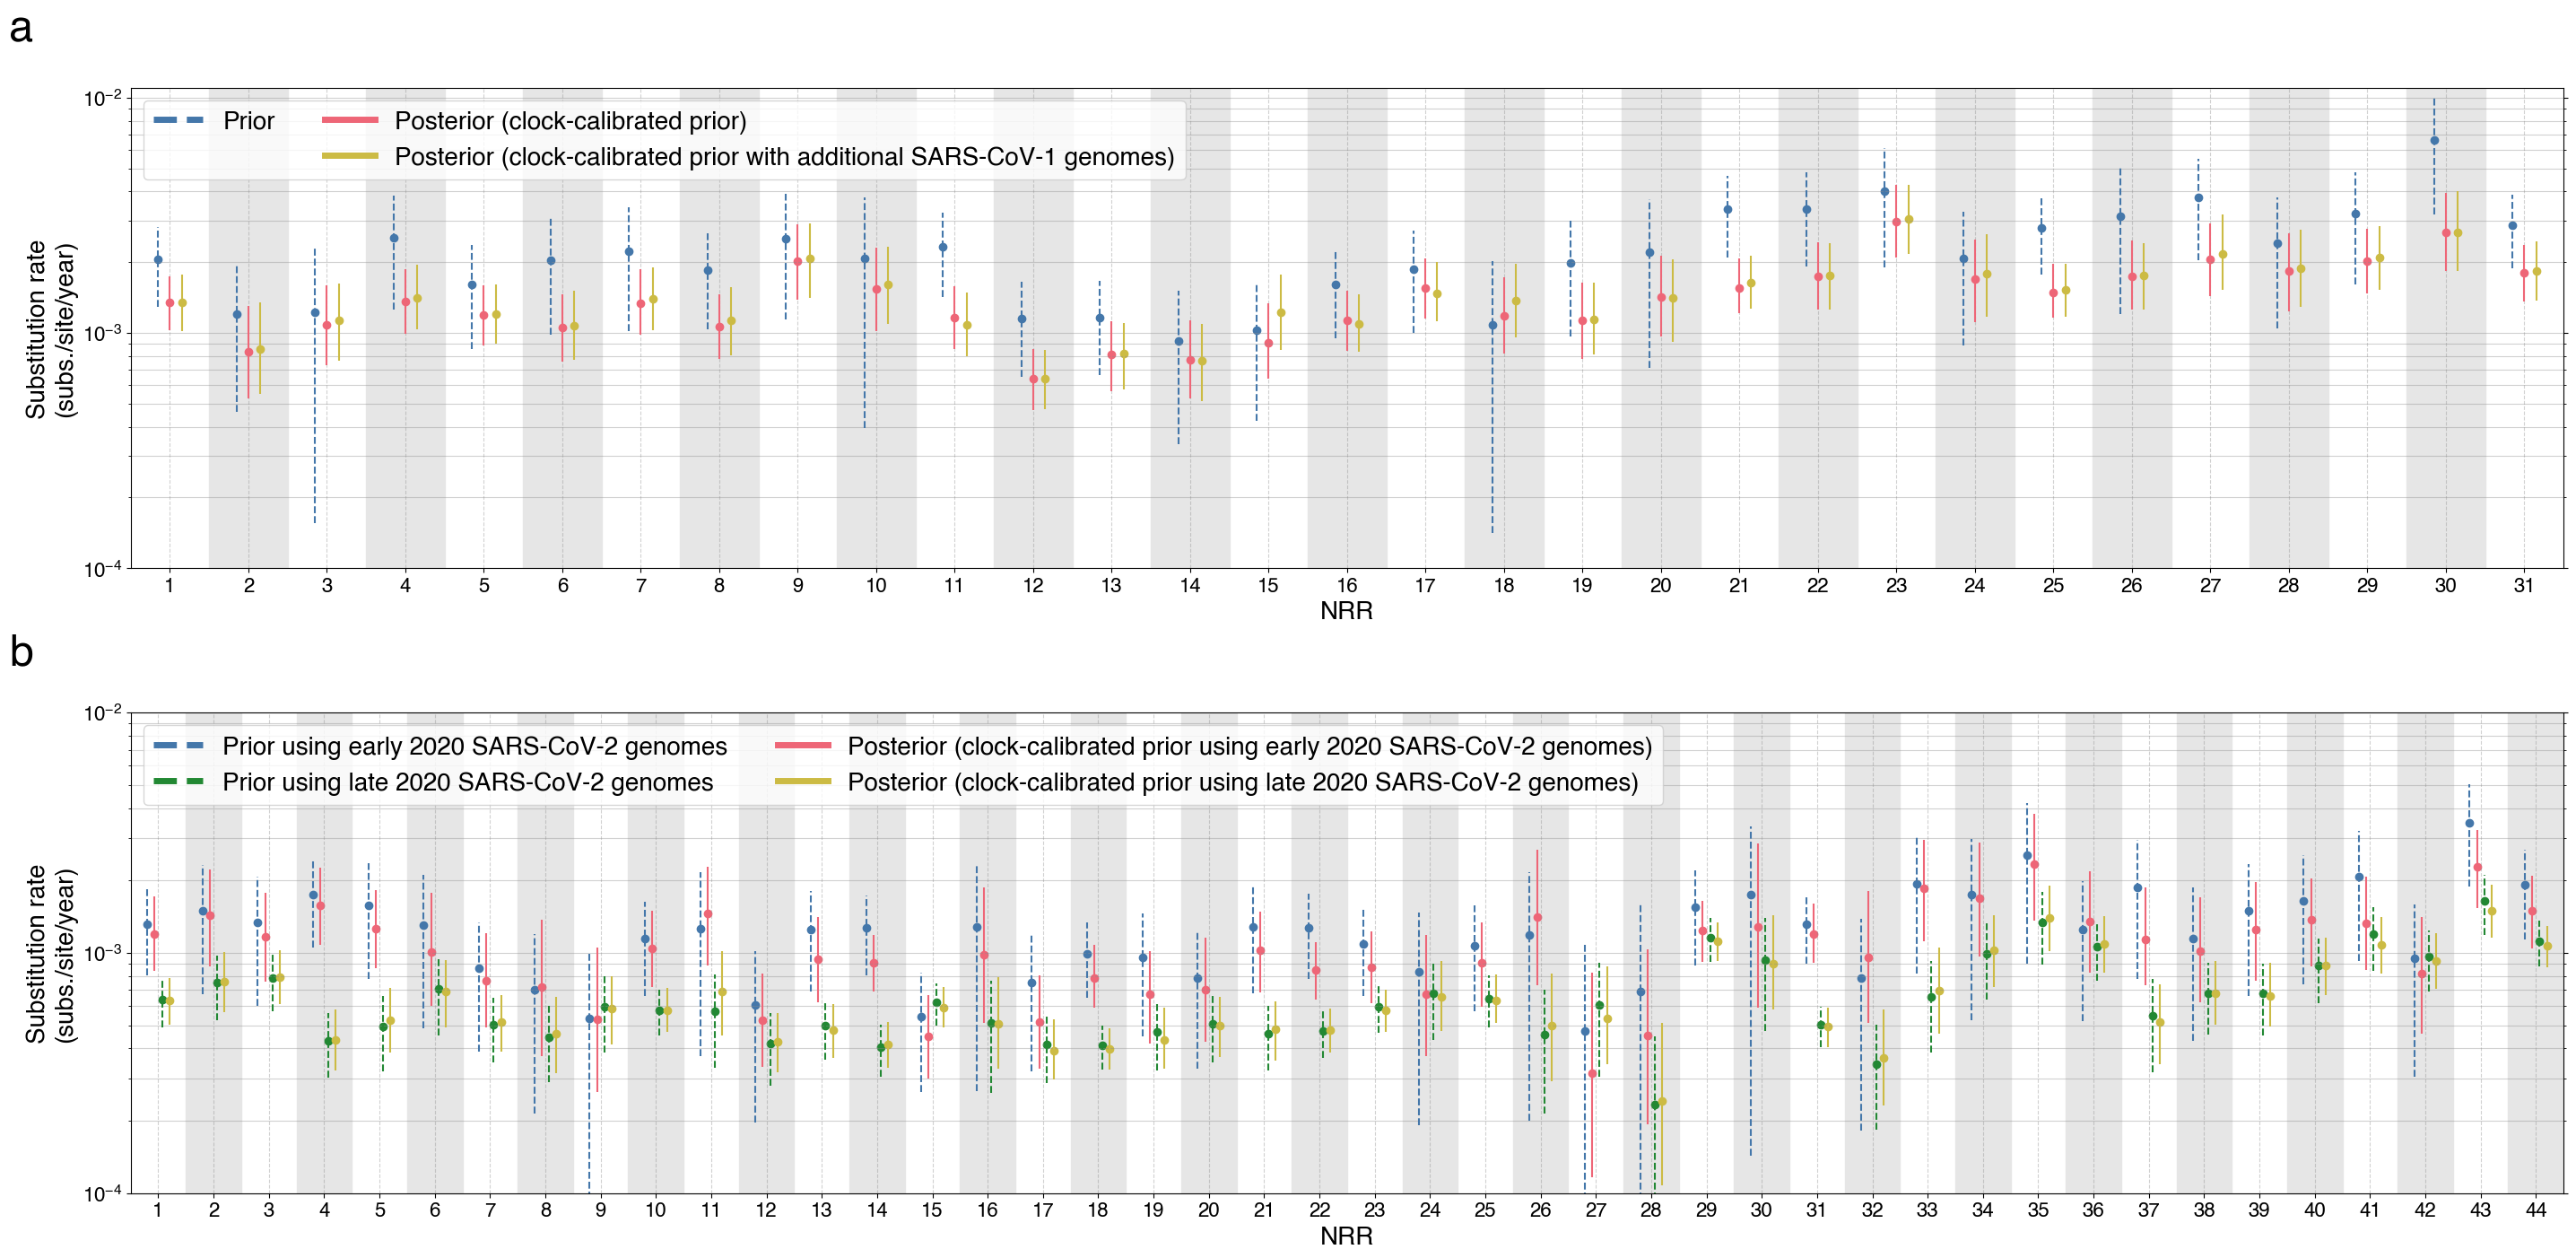

In [11]:
def plot_clock_rates(combined_df, output_path, sc, ax, labels):
    '''
    Plot the clock rates for each NRR
    '''
    rcParams['font.family'] = 'Helvetica'
    # plot clock rates
    # fig, ax = plt.subplots(1, 1, figsize=(40,8), facecolor='white')
    num_results = len([x for x in combined_df.columns if 'median' in x or 'mean' in x])
    cset = list(tc.tol_cset('bright'))

    print(num_results)
    for index, row in combined_df.iterrows():
        # grey column for even nrrs
        if row['NRR'] % 2 == 0:
            ax.add_patch(patches.Rectangle((row['NRR']-0.5, 0), 1, 1, color='0.9'))

        x_locs = np.linspace(row['NRR']-(num_results*0.1)/2, row['NRR']+(num_results*0.1)/2, num_results)

        ax.scatter(x_locs[0], row[combined_df.columns[1]], color=cset[0])
        ax.vlines(x_locs[0], row[combined_df.columns[2]][0], row[combined_df.columns[2]][1], color=cset[0], linestyles='dashed')

        ax.scatter(x_locs[1], row[combined_df.columns[3]], color=cset[1])
        ax.vlines(x_locs[1], row[combined_df.columns[4]][0], row[combined_df.columns[4]][1], color=cset[1])

        if len(combined_df.columns) <= 7:
            ax.scatter(x_locs[2], row[combined_df.columns[5]], color=cset[3])
            ax.vlines(x_locs[2], row[combined_df.columns[6]][0], row[combined_df.columns[6]][1], color=cset[3])

        if len(combined_df.columns) > 7:
            ax.scatter(x_locs[2], row[combined_df.columns[5]], color=cset[2])
            ax.vlines(x_locs[2], row[combined_df.columns[6]][0], row[combined_df.columns[6]][1], color=cset[2], linestyles='dashed')

            ax.scatter(x_locs[3], row[combined_df.columns[7]], color=cset[3])
            ax.vlines(x_locs[3], row[combined_df.columns[8]][0], row[combined_df.columns[8]][1], color=cset[3])

        

    # create custom legend for these 4 analyses
    custom_lines = [Line2D([0], [0], color=cset[0], lw=5, linestyle='dashed'),
                    Line2D([0], [0], color=cset[1], lw=5)
                    ]
    if len(combined_df.columns) <= 7:
        custom_lines.append(Line2D([0], [0], color=cset[3], lw=5))
        invisible_line = Line2D([0], [0], color='none', lw=0) # Invisible line
        custom_lines = [custom_lines[0], invisible_line, custom_lines[1], custom_lines[2]]
        labels = [labels[0], None, labels[1], labels[2]]
    elif len(combined_df.columns) > 7:
        custom_lines.append(Line2D([0], [0], color=cset[2], lw=5, linestyle='dashed'))
        custom_lines.append(Line2D([0], [0], color=cset[3], lw=5))
        custom_lines = [custom_lines[0], custom_lines[2], custom_lines[1], custom_lines[3]]
        labels = [labels[0], labels[2], labels[1], labels[3]]
    
    loc = 'upper left'
    ncol = 2
    ax.legend(custom_lines, labels, loc=loc, fontsize=20, ncol=ncol)

    ymin = min([x[0]*0.9 for x in combined_df[combined_df.columns[2]]])
    ymax = max([x[1]*1.1 for x in combined_df[combined_df.columns[2]]])
    # if ymin > 0.0001:
    #     ymin = 0.0001
    # elif ymin < 0.00001:
    #     ymin = 0.00001
    ymin = 0.0001
    if ymax < 0.01:
        ymax = 0.01
    ax.set_ylim([ymin, ymax])
    ax.set_yscale('log')
    ax.set_xlim([0.5, len(combined_df)+0.5])


    ax.grid(visible=True, which="both", axis='x', ls="--", alpha=0.4, color='0.55')
    ax.grid(visible=True, which="both", axis='y', ls="-", alpha=0.4, color='0.55')
    ax.tick_params(which="both", bottom=True, left=True, right=True)


    ax.set_xlabel('NRR', fontsize=20)
    ax.set_ylabel('Substitution rate\n(subs./site/year)', fontsize=20)
    ax.set_xticks(combined_df['NRR'])
    # ax.set_xticklabels([str(x) for x in ax.get_xticks()], fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=16)

fig, axes = plt.subplots(2, 1, figsize=(35,16), facecolor='white')
plot_clock_rates(sc1_df, './', sc=1, ax=axes[0], labels=['Prior', 'Posterior (clock-calibrated prior)', 'Posterior (clock-calibrated prior with additional SARS-CoV-1 genomes)'])
plot_clock_rates(sc2_df, './', sc=2, ax=axes[1], labels=['Prior using early 2020 SARS-CoV-2 genomes', 'Posterior (clock-calibrated prior using early 2020 SARS-CoV-2 genomes)', 'Prior using late 2020 SARS-CoV-2 genomes', 'Posterior (clock-calibrated prior using late 2020 SARS-CoV-2 genomes)'])

axes[0].text(-0.05, 1.1, 'a', transform=axes[0].transAxes, size=35, weight='bold')
axes[1].text(-0.05, 1.1, 'b', transform=axes[1].transAxes, size=35, weight='bold')
plt.subplots_adjust(hspace=0.3)

plt.savefig('../sarbecovirus_proximal_ancestors/figures/FigSX_clock_rates.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

#  Table

In [7]:
sc1_table_df = pd.read_csv('../sarbecovirus_proximal_ancestors/beast_results/clock_priors/SC1_clock_calibration.tsv', sep='\t')

def format_clock_rate(x):
    return "{:.{dp}e}".format(x, dp=2)
sc1_table_df['Clock calibration prior'] = sc1_table_df.apply(lambda row: format_clock_rate(row['mean']) + ' (' + format_clock_rate(row['stdev']) + ')', axis=1)
sc1_table_df.drop(columns=['mean', 'stdev'], inplace=True)
sc1_table_df['Bayesian divergence time estimation clock posterior'] = [format_clock_rate(sc1_medians[nrr]) + ' (' + format_clock_rate(sc1_hpd[nrr][0]) + ', ' + format_clock_rate(sc1_hpd[nrr][1]) + ')' for nrr in sc1_medians.keys()]

sc2_early2020_table_df = pd.read_csv('../sarbecovirus_proximal_ancestors/beast_results/clock_priors_revision/sc2_calibration_revision/SC2.clock_rates.early2020.tsv', sep='\t')
sc2_late2020_table_df = pd.read_csv('../sarbecovirus_proximal_ancestors/beast_results/clock_priors_revision/sc2_calibration_revision/SC2.clock_rates.late2020.tsv', sep='\t')

sc2_early2020_table_df['Clock calibration prior'] = sc2_early2020_table_df.apply(lambda row: format_clock_rate(row['mean']) + ' (' + format_clock_rate(row['stdev']) + ')', axis=1)
sc2_early2020_table_df.drop(columns=['mean', 'stdev'], inplace=True)
sc2_early2020_table_df['Bayesian divergence time estimation clock posterior'] = [format_clock_rate(sc2_early_medians[nrr]) + ' (' + format_clock_rate(sc2_early_hpd[nrr][0]) + ', ' + format_clock_rate(sc2_early_hpd[nrr][1]) + ')' for nrr in sc2_early_medians.keys()]

sc2_late2020_table_df['Clock calibration prior'] = sc2_late2020_table_df.apply(lambda row: format_clock_rate(row['mean']) + ' (' + format_clock_rate(row['stdev']) + ')', axis=1)
sc2_late2020_table_df.drop(columns=['mean', 'stdev'], inplace=True)
sc2_late2020_table_df['Bayesian divergence time estimation clock posterior'] = [format_clock_rate(sc2_late_medians[nrr]) + ' (' + format_clock_rate(sc2_late_hpd[nrr][0]) + ', ' + format_clock_rate(sc2_late_hpd[nrr][1]) + ')' for nrr in sc2_late_medians.keys()]

sc1_table_df.to_csv('../sarbecovirus_proximal_ancestors/figures/SC1_clock_rates_table.revision.tsv', sep='\t', index=False)
sc2_early2020_table_df.to_csv('../sarbecovirus_proximal_ancestors/figures/SC2_early2020_clock_rates_table.revision.tsv', sep='\t', index=False)
sc2_late2020_table_df.to_csv('../sarbecovirus_proximal_ancestors/figures/SC2_late2020_clock_rates_table.revision.tsv', sep='\t', index=False)